## Solved using Convolutional Neural Networks

In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
import numpy
numpy.set_printoptions(threshold=10000,edgeitems = 10) #threshold=sys.maxsize

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))


['digit-recognizer']


If you don't already have [Keras][1], you can easily install it through conda or pip. It relies on either tensorflow or theano, so you should have these installed first. Keras is already available here in the kernel and on Amazon deep learning AMI.

  [1]: https://keras.io/

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
train_file = "../input/digit-recognizer/train.csv"
test_file = "../input/digit-recognizer/test.csv"
sample_submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

## Load the data

As always, we split the data into a training set and a validation set, so that we can evaluate the performance of our model.

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

Each data point consists of 784 values. A fully connected net just treats all these values the same, but a CNN treats it as a 28x28 square. Thes two graphs explain the difference: It's easy to understand why a CNN can get better results.

Text(0.5, 1.0, '28x28 data')

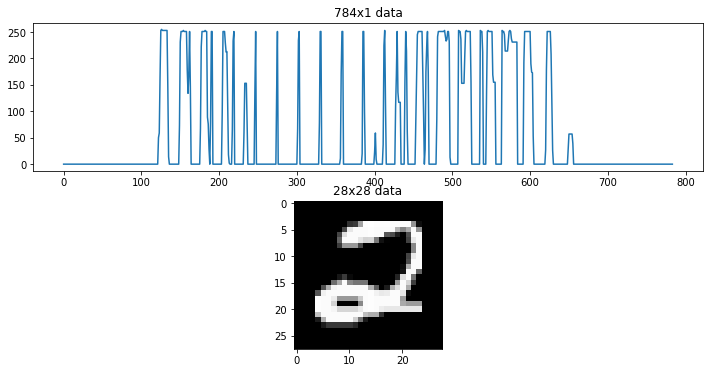

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

In [6]:
print(y_train[::]) # displays the Digits availabe corresponding to traning data.
y_train.shape

[2 2 6 4 1 6 3 8 9 1 ... 9 7 2 1 0 3 1 4 9 7]


(37800,)

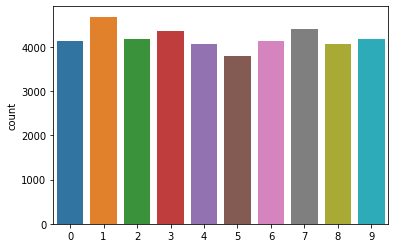

In [7]:
#Now we'll display the total count of each digits.
sns.countplot(raw_data[:,0]) #this will select the first column vales from the dataset

We now reshape all data this way. Keras wants an extra dimension in the end, for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses one.

This notebook is written for the tensorflow channel ordering. If you have Keras installed for Theano backend, you might start seeing some error message soon related to channel ordering. This can easily be [solved][1].


  [1]: https://keras.io/backend/#set_image_dim_ordering

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster. 

In [9]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Train the model

Keras offers two different ways of defining a network. We will the Sequential API, where you just add on one layer at a time, starting from the input.

The most important part are the convolutional layers Conv2D. Here they have 16-32 filters that use nine weights each to transform a pixel to a weighted average of itself and its eight neighbors. As the same nine weights are used over the whole image, the net will pick up features that are useful everywhere. As it is only nine weights, we can stack many convolutional layers on top of each other without running out of memory/time. 

The MaxPooling layers just look at four neighboring pixels and picks the maximal value. This reduces the size of the image by half, and by combining convolutional and pooling layers, the net be able to combine its features to learn more global features of the image. In the end we use the features in two fully-connected (Dense) layers.

Batch Normalization is a technical trick to make training faster. Dropout is a regularization method, where the layer randomly replaces  a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization. 'relu' is the activation function x -> max(x,0).

In [11]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Another important method to improve generalization is augmentation. This means generating more training data by randomly perturbing the images. If done in the right way, it can force the net to only learn translation-invariant features. If you train this model over hundreds of epochs, augmentation will definitely improve your performance. Here in the Kernel, we will only look at each image 4-5 times, so the difference is smaller. We use a Keras function for augmentation.

In [12]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this: 

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

We will use a very small validation set during training to save time in the kernel.

In [15]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/20
 - 13s - loss: 0.7967 - accuracy: 0.7444 - val_loss: 0.1456 - val_accuracy: 0.9425
Epoch 2/20
 - 8s - loss: 0.3200 - accuracy: 0.9072 - val_loss: 0.0612 - val_accuracy: 0.9800
Epoch 3/20
 - 7s - loss: 0.2250 - accuracy: 0.9309 - val_loss: 0.0586 - val_accuracy: 0.9775
Epoch 4/20
 - 7s - loss: 0.2004 - accuracy: 0.9379 - val_loss: 0.0762 - val_accuracy: 0.9825
Epoch 5/20
 - 7s - loss: 0.1780 - accuracy: 0.9498 - val_loss: 0.0570 - val_accuracy: 0.9800
Epoch 6/20
 - 7s - loss: 0.1611 - accuracy: 0.9529 - val_loss: 0.0733 - val_accuracy: 0.9800
Epoch 7/20
 - 7s - loss: 0.1406 - accuracy: 0.9591 - val_loss: 0.0485 - val_accuracy: 0.9825
Epoch 8/20
 - 7s - loss: 0.1197 - accuracy: 0.9652 - val_loss: 0.0728 - val_accuracy: 0.9775
Epoch 9/20
 - 7s - loss: 0.1256 - accuracy: 0.9622 - val_loss: 0.0247 - val_accuracy: 0.9900
Epoch 10/20
 - 8s - loss: 0.1137 - accuracy: 0.9676 - val_loss: 0.0365 - val_accuracy: 0.9850
Epoch 11/20
 - 7s - loss: 0.1098 - accuracy: 0.9684 - val_loss: 0.02

## Evaluate

We only used a subset of the validation set during training, to save time. Now let's check performance on the whole validation set.

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0244, final accuracy: 0.9931


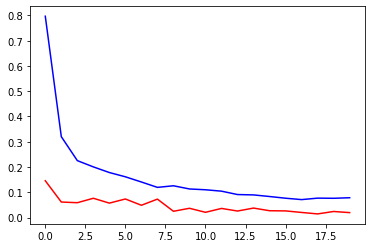

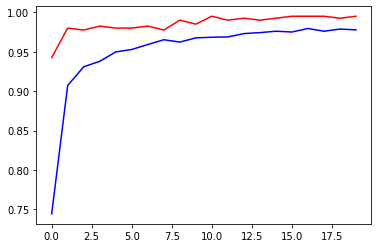

In [17]:
#First graph is comparison of Training Loss and Validation loss
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
#Second graph is comparison of Training accuracy and Validation Accuracy.
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [18]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[442   0   0   0   1   0   0   0   1   0]
 [  0 448   1   0   0   0   0   1   0   0]
 [  0   0 414   0   0   0   0   1   0   0]
 [  0   0   1 482   0   1   0   1   0   0]
 [  0   0   0   0 407   0   0   2   1   4]
 [  0   0   0   0   0 337   0   0   0   0]
 [  0   0   0   0   0   0 426   0   1   0]
 [  0   0   1   0   1   0   0 414   0   0]
 [  0   0   0   0   0   0   0   0 359   1]
 [  1   0   0   0   1   4   0   2   2 442]]


Not too bad, considering the minimal amount of training so far. In fact, we have only gone through the training data approximately five times. With proper training we should get really good results.

As you can see there are quite a few parameters that could be tweaked (number of layers, number of filters, Dropout parameters, learning rate, augmentation settings). This is often done with trial and error, and there is no easy shortcut. 

Getting convergence should not be a problem, unless you use an extremely large learning rate. It's easy, however, to create a net that overfits, with perfect results on the training set and very poor results on the validation data. If this happens, you could try increasing the Dropout parameters, increase augmentation, or perhaps stop training earlier. If you instead wants to increase accuracy, try adding on two more layers, or increase the number of filters.

## Submit

To easily get to the top half of the leaderboard, just follow these steps, go to the Kernel's output, and submit "submission.csv"

In [19]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [20]:
y_hat = model.predict(x_test, batch_size=64)

y_hat consists of class probabilities (corresponding to the one-hot encoding of the training labels). I now select the class with highest probability

In [21]:
y_pred = np.argmax(y_hat,axis=1)

In [22]:
solution = pd.DataFrame({'ImageId': sample_submission['ImageId'], 'Label': y_pred})
solution[["ImageId","Label"]].to_csv("CNNPrediction.csv", index=False)
solution.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


Submitting from this notebook usually gives you a result around 99%, with some randomness depending on weight initialization and test/train data split. I achieved 99.3% by averaging over 5 good runs, and you can get higher than that if you train overnight.

If you've successfully come this far, you can now create similar CNN for all kinds of image recognition problems. Good luck!